# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [12]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [13]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
# !pip list | grep -i numpy
# !pip install --upgrade numpy

In [15]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report

In [16]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [17]:
# define a function to load json file to a dataframe
def load_json_dataframe(file_name):
    try:
        with open(file_name, 'r') as json_file:
            output = json.load(json_file)
        df = pd.DataFrame(output)
        return df
    except Exception as e:
        print('Error loading JSON input file', e)
        return pd.DataFrame()

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [18]:
# read the json file by giving the file path and create a dataframe
df = load_json_dataframe('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [19]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [20]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [21]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [22]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].str.split()

# Tokenize POS
df['pos_tokens'] = df['pos'].str.split()

In [23]:
# display first five rows of the dataframe - df
df.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [24]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [25]:
# check for the equality of input_length and pos_length in the dataframe
# df.head()
matched_df = df[df['input_length'] == df['pos_length']]
matched_df.shape

(280, 6)

In [26]:
# Printing top matched rows
matched_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablesp

In [27]:
# Printing non-matched rows
unmatched_df = df[df['input_length'] != df['pos_length']]
print(unmatched_df.shape)
unmatched_df

(5, 6)


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                                                                                                                                                                                                                                                                input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
17                                                                                                                                                                                                                                                   2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt                                                                                                                                                                                                                                                                                                                                                                                                                 quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                         [2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]                                                                                                                                                                                                                                                                                                                                                                                                                                                        [quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          14
27                                                                                   1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce                                                                                                                                                               quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient in

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [28]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(input_df):
    unique_pos_labels = set(pos_token for pos_row in input_df for pos_token in pos_row)
    print("Unique Labels are: ", sorted(unique_pos_labels))
    return unique_pos_labels

In [29]:
unique_labels(df['pos_tokens'])

Unique Labels are:  ['ingredient', 'quantity', 'unit']


{'ingredient', 'quantity', 'unit'}

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [30]:
unmatched_indexes = df[df['input_length'] != df['pos_length']].index.tolist()
print(f"Indexes that requires cleaning and formatting in data frame are:\n{unmatched_indexes}")

Indexes that requires cleaning and formatting in data frame are:
[17, 27, 79, 164, 207]


<font color = red>Indexes [17, 27, 79, 164, 207] requires cleaning and formatting in the input dataframe because: </font> <br>
- The length of Input Tokens and PoS Tokens aren't equal.

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [31]:
# drop the irrelevant recipe data
df.drop(index=unmatched_indexes, inplace=True) # Dropping Index
df.reset_index(drop=True, inplace=True) #Resetting Index

In [32]:
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablesp

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [33]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [34]:
# validate the input length and pos length as input_length and pos_length
unmatched_df = df[df['input_length'] != df['pos_length']]
unmatched_df.shape

(0, 6)

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [35]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [36]:
# print the first five rows of train_df
train_df.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length
175                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                                                                        quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
55   200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ing

In [37]:
# print the first five rows of the val_df
val_df.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length
33                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15
108  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi P

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [38]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens']
y_train = train_df['pos_tokens']

X_val = val_df['input_tokens']
y_val = val_df['pos_tokens']

In [39]:
# validate the shape of training and validation samples
print("Length of X_train: ", len(X_train))
print("Length of y_train: ", len(y_train))
print("Length of X_test: ", len(X_val))
print("Length of y_test: ", len(y_val))

Length of X_train:  196
Length of y_train:  196
Length of X_test:  84
Length of y_test:  84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [40]:
# Display the number of unique labels present in y_train
unique_labels(y_train)

Unique Labels are:  ['ingredient', 'quantity', 'unit']


{'ingredient', 'quantity', 'unit'}

## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [41]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    return [item for each_list in nested_list for item in each_list]

In [42]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [43]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    flat_input_tokens = flatten_list(df['input_tokens'])
    flat_pos_tokens = flatten_list(df['pos_tokens'])
    if len(flat_input_tokens) == len(flat_pos_tokens):
        print(f"Tokens Length Matches: Input & PoS ({len(flat_input_tokens)})")
    else:
        print(f"Tokens Length Mismatches: Input ({len(flat_input_tokens)}) & PoS tokens length ({len(flat_pos_tokens)})")

    # Printing 1st 10 records
    print("First 10 Input<-->POS pair")
    for input, pos in zip(flat_input_tokens[:10], flat_pos_tokens[:10]):
        print(f"{input:15} -> {pos}")

In [44]:
# extract the tokens and its pos tags
extract_and_validate_tokens(train_df, "Training")
extract_and_validate_tokens(val_df, "Validation")

Tokens Length Matches: Input & PoS (7114)
First 10 Input<-->POS pair
250             -> quantity
grams           -> unit
Okra            -> ingredient
Oil             -> ingredient
1               -> quantity
Onion           -> ingredient
finely          -> ingredient
chopped         -> ingredient
Tomato          -> ingredient
Grated          -> ingredient
Tokens Length Matches: Input & PoS (2876)
First 10 Input<-->POS pair
1               -> quantity
cup             -> unit
Ada             -> ingredient
2               -> quantity
liter           -> unit
Milk            -> ingredient
3/4             -> quantity
Sugar           -> ingredient
tablespoon      -> unit
Ghee            -> ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [45]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    valid_labels = {'ingredient', 'unit', 'quantity'}

    # Validating POS tags
    if not all(tag in valid_labels for tag in pos_tags):
        return [], [], []

    # Initializing lists
    ingredient = []
    unit = []
    quantity = []

    # Categorizing based on POS tags
    for token, tag in zip(tokens, pos_tags):
        if tag == 'ingredient':
            ingredient.append(token)
        elif tag == 'unit':
            unit.append(token)
        elif tag == 'quantity':
            quantity.append(token)

    return ingredient, unit, quantity

In [46]:
#  call the function to categorise the labels into respective list

# Flatten training data
flat_input_tokens = flatten_list(train_df['input_tokens'].tolist())
flat_pos_tokens = flatten_list(train_df['pos_tokens'].tolist())

# Categorizing and validating
ingredients, units, quantities = categorize_tokens(flat_input_tokens, flat_pos_tokens)

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [47]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label, dataset_name):
    counter = Counter(item_list)
    top_items = counter.most_common(10)
    print(f"\n Top 10 frequent '{pos_label}' tokens in {dataset_name} dataset:")
    for token, count in top_items:
        print(f"{token:20} -> {count} times")
    return top_items

In [48]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients,'ingredient', 'Training')


 Top 10 frequent 'ingredient' tokens in Training dataset:
powder               -> 129 times
Salt                 -> 102 times
seeds                -> 89 times
Green                -> 85 times
chopped              -> 84 times
Oil                  -> 83 times
Red                  -> 81 times
Chilli               -> 77 times
Coriander            -> 71 times
Sunflower            -> 65 times


In [49]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units,'units', 'Training')


 Top 10 frequent 'units' tokens in Training dataset:
teaspoon             -> 162 times
cup                  -> 136 times
tablespoon           -> 99 times
grams                -> 63 times
tablespoons          -> 61 times
inch                 -> 52 times
cups                 -> 50 times
sprig                -> 41 times
cloves               -> 39 times
teaspoons            -> 39 times


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [50]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

def plot_top_items(top_item_list, label, dataset_name):
    if not top_item_list:
        print(f"no data available for {label} in {dataset_name} dataset")
        return
    items, counts = zip(*top_item_list)
    plt.figure(figsize=(10,5))
    plt.bar(items,counts)
    plt.title(f"Top 10 {label.capitalize()} in {dataset_name} Dataset")
    plt.xlabel(f"{label.capitalize()}")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



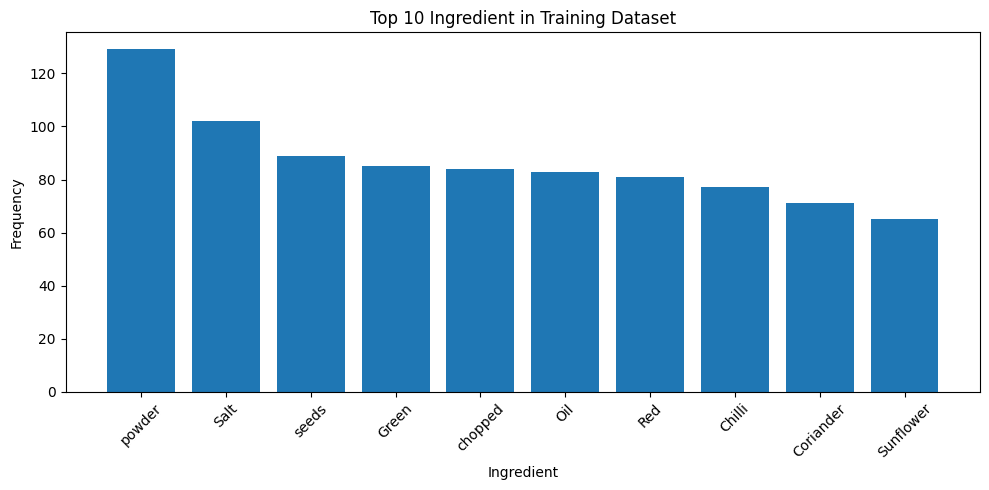

In [51]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients,'ingredient', 'Training')

In [52]:
# plot the top frequent units in training data
plot_top_items(top_units,'units', 'Training')

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [53]:
# initialise the dataset_name
validate_dataset_name = "Validation"

In [54]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
extract_and_validate_tokens(val_df, validate_dataset_name)

# Flatten training data
validate_flat_input_tokens = flatten_list(val_df['input_tokens'].tolist())
validate_flat_pos_tokens = flatten_list(val_df['pos_tokens'].tolist())

# Categorizing and validating
validate_ingredients, validate_units, validate_quantities = categorize_tokens(validate_flat_input_tokens, validate_flat_pos_tokens)

Tokens Length Matches: Input & PoS (2876)
First 10 Input<-->POS pair
1               -> quantity
cup             -> unit
Ada             -> ingredient
2               -> quantity
liter           -> unit
Milk            -> ingredient
3/4             -> quantity
Sugar           -> ingredient
tablespoon      -> unit
Ghee            -> ingredient



 Top 10 frequent 'ingredient' tokens in Validate dataset:
powder               -> 54 times
Salt                 -> 47 times
Oil                  -> 39 times
Red                  -> 39 times
seeds                -> 36 times
Chilli               -> 36 times
chopped              -> 31 times
Green                -> 30 times
Leaves               -> 29 times
Coriander            -> 27 times


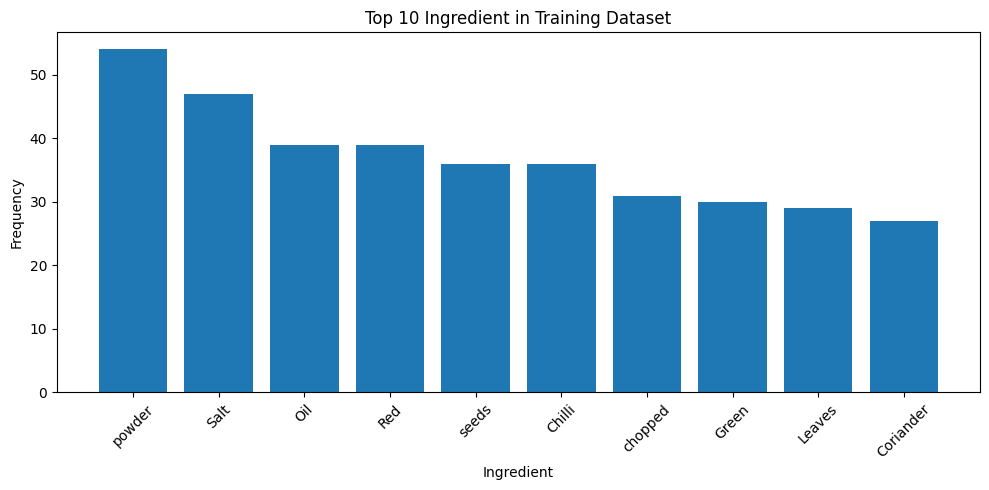

In [55]:
# plot the top frequent ingredients in validation data
validate_top_ingredients = get_top_frequent_items(validate_ingredients,'ingredient', 'Validate')
plot_top_items(validate_top_ingredients,'ingredient', 'Training')


 Top 10 frequent 'units' tokens in Validate dataset:
teaspoon             -> 59 times
cup                  -> 57 times
tablespoon           -> 32 times
tablespoons          -> 32 times
cups                 -> 24 times
sprig                -> 21 times
inch                 -> 20 times
grams                -> 19 times
teaspoons            -> 18 times
cloves               -> 16 times


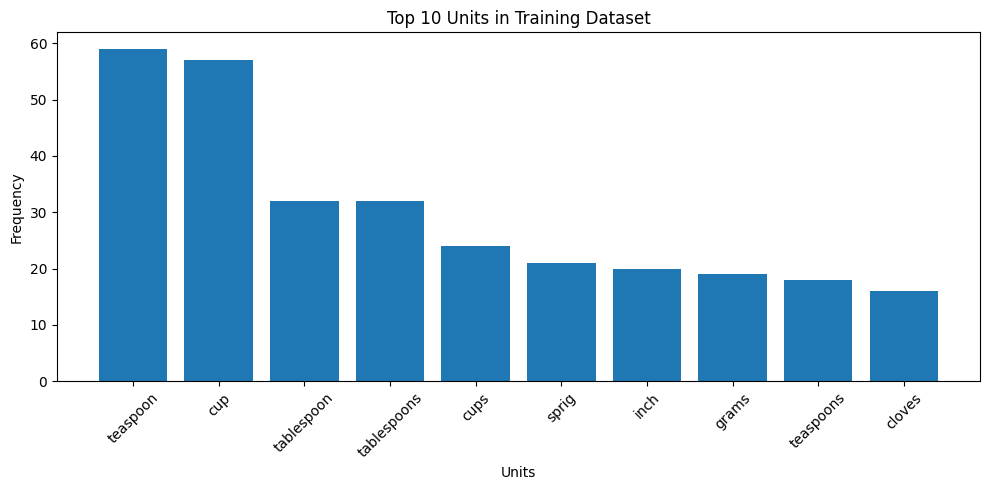

In [56]:
# plot the top frequent units in training data
validate_top_units = get_top_frequent_items(validate_units,'units', 'Validate')
plot_top_items(validate_top_units,'units', 'Training')

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [57]:
# define unit and quantity keywords along with quantity pattern

# Unit-related keywords commonly used in cooking measurements
unit_keywords = {
    "cup", "cups", "tablespoon", "tablespoons", "tbsp", "teaspoon", "teaspoons", "tsp",
    "oz", "ounce", "ounces", "lb", "lbs", "pound", "pounds", "g", "gram", "grams",
    "kg", "kilogram", "kilograms", "ml", "milliliter", "milliliters", "l", "liter", "liters",
    "pinch", "dash", "clove", "cloves", "slice", "slices", "can", "cans", "stick", "sticks",
    "quart", "quarts", "pint", "pints", "bottle", "bottles", "bag", "bags", "package", "packages"
}

# Quantity-related keywords indicating numerical or vague amounts
quantity_keywords = {
    "half", "quarter", "third", "fourth", "one", "two", "three", "four", "five", "six",
    "seven", "eight", "nine", "ten", "dozen", "several", "few", "some", "many", "couple"
}

# Regex to match whole numbers, decimals, simple fractions, and mixed fractions
quantity_pattern = re.compile(r'^(\d+(\.\d+)?|\d+/\d+|\d+\s+\d+/\d+)$')

In [58]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [59]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---

def is_quantity(token_text):
    return token_text.lower() in quantity_keywords or bool(quantity_pattern.match(token_text))

def is_fraction(token_text):
    return bool(re.match(r'^\d+/\d+$', token_text))

def is_decimal(token_text):
    return bool(re.match(r'^\d+\.\d+$', token_text))

def word2features(sent, i):
    token = sent[i]
    features = {
        'bias': 1.0,
        'token': token.text.lower(),
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.is_digit,
        'has_digit': any(c.isdigit() for c in token.text),
        'has_alpha': any(c.isalpha() for c in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.text.istitle(),
        'is_upper': token.text.isupper(),
        'is_punct': token.is_punct,

        # Quantity and unit detection
        'is_quantity': is_quantity(token.text),
        'is_unit': token.text.lower() in unit_keywords,
        'is_numeric': token.like_num,
        'is_fraction': is_fraction(token.text),
        'is_decimal': is_decimal(token.text),

        # Previous and next words
        'preceding_word': sent[i-1].text.lower() if i > 0 else '',
        'following_word': sent[i+1].text.lower() if i < len(sent) - 1 else '',

        # Contextual flags
        'prev_token': sent[i-1].text.lower() if i > 0 else '',
        'prev_is_quantity': is_quantity(sent[i-1].text) if i > 0 else False,
        'prev_is_digit': sent[i-1].like_num if i > 0 else False,
        'BOS': i == 0,

        'next_token': sent[i+1].text.lower() if i < len(sent) - 1 else '',
        'next_is_unit': sent[i+1].text.lower() in unit_keywords if i < len(sent) - 1 else False,
        'next_is_ingredient': (sent[i+1].text.lower() not in unit_keywords and not is_quantity(sent[i+1].text)) if i < len(sent) - 1 else False,
        'EOS': i == len(sent) - 1,
    }

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [60]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [61]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
def extract_feature_list(recipe_list):
    feature_sets = []
    for recipe in recipe_list:
        if isinstance(recipe, str):  # Check if recipe is a string
            doc = nlp(recipe)  # Process the string with spaCy
            for sent in doc.sents:
                features = sent2features(sent)
                feature_sets.append(features)
        else:
            print(f"Skipping non-string entry: {recipe}")
    return feature_sets


In [62]:
# Convert into feature set
X_train_features = extract_feature_list(flat_input_tokens)
X_val_features = extract_feature_list(validate_flat_input_tokens)

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [63]:
# Convert labels into list as y_train_labels and y_val_labels

y_train_labels  = extract_feature_list(flat_pos_tokens)
y_val_labels  = extract_feature_list(validate_flat_pos_tokens)

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [64]:
# print the length of train features and labels
print(f"X train features length {len(X_train_features)}")
print(f"y train labels length {len(y_train_labels)}")

X train features length 7114
y train labels length 7114


In [65]:
# print the length of validation features and labels
print(f"X validation features length {len(X_val_features)}")
print(f"y validation labels length {len(y_val_labels)}")

X validation features length 2876
y validation labels length 2876


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [66]:
# Flatten labels in y_train
y_train_flat = flatten_list(y_train)

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [67]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)

total_samples = sum(label_counts.values())
print(f"labels count: {label_counts}")
print(f"Total samples count: {total_samples}")

labels count: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total samples count: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [68]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

# Number of unique labels
num_classes = len(label_counts)

# Computing class weights using inverse frequency
class_weights = {
    label: total_samples / (count * num_classes)
    for label, count in label_counts.items()
}

# Displaying the result
print("Class Weights:")
for label, weight in class_weights.items():
    print(f"{label}: {weight:.4f}")

Class Weights:
quantity: 2.4197
unit: 2.9240
ingredient: 0.4455


In [69]:
# penalise ingredient label

# copying the existing weights to modify
penalized_class_weights = class_weights.copy()

# Applying a penalty factor
penalty_factor = 0.5
penalized_class_weights['ingredient'] *= penalty_factor


# Displaying updated weight for 'ingredient'
print(f"Updated weight for 'ingredient': {penalized_class_weights['ingredient']:.4f}")

Updated weight for 'ingredient': 0.2227


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [70]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)

def extract_features_with_class_weights(X_train, X_val, y_train, penalize_label=None, penalty_factor=1.0):
    # Flattening the labels
    y_train_flat = [label for sent in y_train for label in sent]

    # Counting label frequencies
    label_counts = Counter(y_train_flat)
    total_samples = sum(label_counts.values())

    # Computing class weights using inverse frequency
    class_weights = {label: total_samples / (len(label_counts) * count) for label, count in label_counts.items()}

    # penalizing specific label (e.g., 'ingredient')
    if penalize_label and penalize_label in class_weights:
        class_weights[penalize_label] *= penalty_factor
        print(f"Penalized weight for '{penalize_label}': {class_weights[penalize_label]:.4f}")

    # Extracting features
    X_train_features = extract_feature_list(X_train)
    X_val_features = extract_feature_list(X_val)

    return X_train_features, X_val_features, class_weights

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [71]:
# Apply manually computed class weights

# Executing the feature extraction with class weights
X_train_weighted_features, X_val_weighted_features, class_weights = extract_features_with_class_weights(
    X_train, X_val, y_train,
    penalize_label='ingredient',
    penalty_factor=0.5  # You can adjust this value if needed
)


Penalized weight for 'ingredient': 0.2227
Skipping non-string entry: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely', '1/2', 'Cumin', 'seeds', '1/4', 'Teaspoon', 'asafoetida', 'cup', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric']
Skipping non-string entry: ['200', 'grams', 'Paneer', 'Homemade', 'Cottage', 'Cheese', '2', 'Potato', 'Aloo', 'Bay', 'leaf', 'tej', 'patta', 'Dry', 'Red', 'Chilli', '1', 'tablespoon', 'Panch', 'Phoran', 'Masala', 'roasted', 'and', 'powdered', 'Tomato', 'big', 'sized', 'teaspoon', 'Turmeric', 'powder', 'Haldi', 'Cumin', 'seeds', 'Jeera', 'Ginger', 'grated', 'Salt', '1/2', 'Sugar', 'Sunflower', 'Oil']
Skipping non-string entry: ['500', 'grams', 'Cabbage', 'Patta', 'Gobi', 'Muttaikose', '1', 'teaspoon', 'Mustard', 'seeds', '1-1/2', 'White', 'Urad', 'Dal', 'Split', 'sprig', 'Curry', 'leaves', 'Green', 'Chilli', '1/4', 'cup', 'Fresh', '

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [72]:
# initialise CRF model with the specified hyperparameters and use weight_dict

crf = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
     max_iterations=100,
    all_possible_transitions=True
)

# Manually adjusting the weights of each training sample based on class labels
# Adjusted data
adjusted_X_train = []
adjusted_y_train = []

for x_seq, y_seq in zip(X_train, y_train):
    # Computing the average weight of all labels in the sequence
    weights = [class_weights.get(label, 1.0) for label in y_seq]
    avg_weight = sum(weights) / len(weights)

    # Repeating the sample based on the average weight
    repeat_factor = int(avg_weight * 10)  # You can tweak the 10 for finer control
    for _ in range(repeat_factor):
        adjusted_X_train.append(x_seq)
        adjusted_y_train.append(y_seq)


# train the CRF model with the weighted training data
crf.fit(adjusted_X_train,adjusted_y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [73]:
# evaluate on the training dataset
y_train_pred = crf.predict(X_train)

In [74]:
# specify the flat classification report by using training data for evaluation

# Flatten the sequences for token-level evaluation
y_train_flat = flatten_list(y_train)
y_train_pred_flat = flatten_list(y_train_pred)

# Evaluate performance
print("CRF Training Set Evaluation:")
print(classification_report(y_train_flat, y_train_pred_flat))

CRF Training Set Evaluation:
              precision    recall  f1-score   support

  ingredient       0.98      0.98      0.98      5323
    quantity       0.99      0.98      0.99       980
        unit       0.90      0.91      0.90       811

    accuracy                           0.98      7114
   macro avg       0.96      0.96      0.96      7114
weighted avg       0.98      0.98      0.98      7114



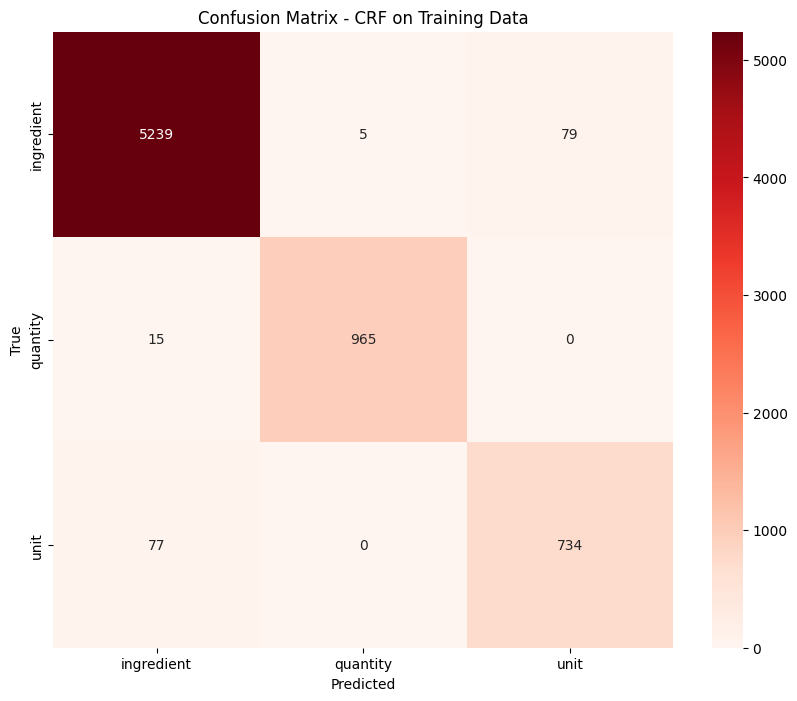

In [75]:
# create a confusion matrix on training datset

# Getting sorted list of labels
labels = sorted(set(y_train_flat + y_train_pred_flat))

cm = confusion_matrix(y_train_flat, y_train_pred_flat, labels=labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CRF on Training Data')
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [76]:
# dump the model using joblib as crf_model.pkl

joblib.dump(crf,'crf_model.pkl')
print("crf model saved as crf_model.pkl")

crf model saved as crf_model.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [77]:
# predict the crf model on validation dataset
y_val_pred = crf.predict(X_val)

In [78]:
# specify flat classification report

# Flattening the sequences for token-level evaluation
y_val_flat = flatten_list(y_val)
y_val_pred_flat = flatten_list(y_val_pred)

# Evaluating the performance
print("CRF Validation Set Evaluation:")
print(classification_report(y_val_flat, y_val_pred_flat))

CRF Validation Set Evaluation:
              precision    recall  f1-score   support

  ingredient       0.97      0.98      0.98      2107
    quantity       0.99      0.99      0.99       411
        unit       0.86      0.86      0.86       358

    accuracy                           0.96      2876
   macro avg       0.94      0.94      0.94      2876
weighted avg       0.96      0.96      0.96      2876



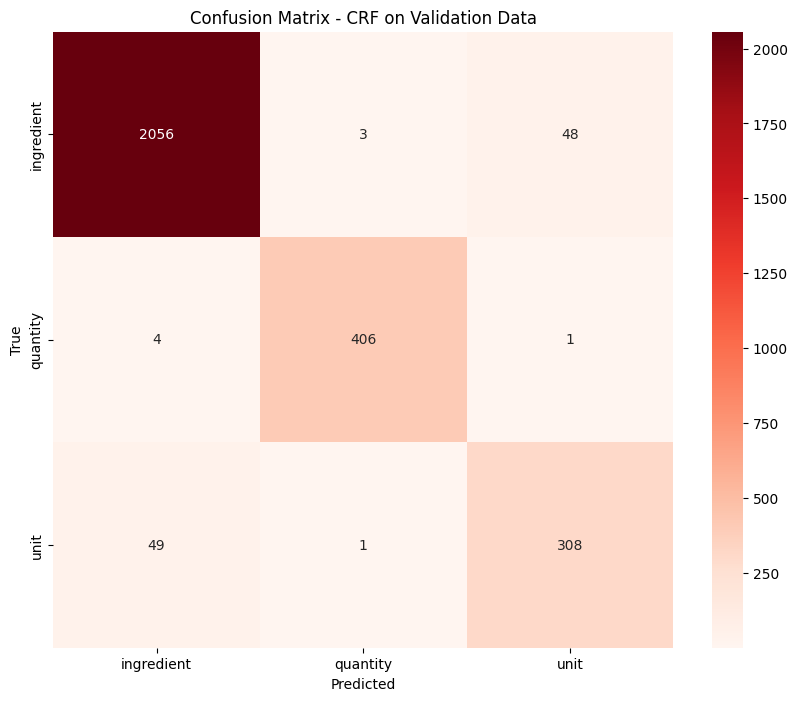

In [79]:
# create a confusion matrix on validation dataset

# Getting sorted list of labels
labels_val = sorted(set(y_val_flat + y_val_pred_flat))

cm_val = confusion_matrix(y_val_flat, y_val_pred_flat, labels=labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Reds', xticklabels=labels_val, yticklabels=labels_val)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CRF on Validation Data')
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [80]:
# flatten Labels and Initialise Error Data

# Flattening label lists
y_val_flat = []
y_val_pred_flat = []

# Error tracking
error_data = []

# Iterating through each sentence
for sent_idx, (true_seq, pred_seq, feature_seq) in enumerate(zip(y_val, y_val_pred, X_val)):
    for token_idx, (true_label, pred_label) in enumerate(zip(true_seq, pred_seq)):
        y_val_flat.append(true_label)
        y_val_pred_flat.append(pred_label)

        # Track errors
        if true_label != pred_label:
            token = feature_seq[token_idx]  # Just use the token string
            error_data.append({
                'sentence_index': sent_idx,
                'token_index': token_idx,
                'token': token,
                'true_label': true_label,
                'predicted_label': pred_label
            })

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [81]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases
# Flattened label lists
y_val_flat = []
y_val_pred_flat = []

# Error tracking
error_data = []

# Iterating through each sentence
for sent_idx, (true_seq, pred_seq, feature_seq) in enumerate(zip(y_val, y_val_pred, X_val)):
    for token_idx, (true_label, pred_label) in enumerate(zip(true_seq, pred_seq)):
        y_val_flat.append(true_label)
        y_val_pred_flat.append(pred_label)

        # Track errors
        if true_label != pred_label:
            # Get the current token
            token = feature_seq[token_idx]

            # Get previous and next tokens with boundary checks
            prev_token = feature_seq[token_idx - 1] if token_idx > 0 else None
            next_token = feature_seq[token_idx + 1] if token_idx < len(feature_seq) - 1 else None

            # Collect the error information along with the previous and next tokens
            error_data.append({
                'sentence_index': sent_idx,
                'token_index': token_idx,
                'token': token,
                'true_label': true_label,
                'predicted_label': pred_label,
                'previous_token': prev_token,
                'next_token': next_token
            })

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [82]:
# Create DataFrame and Print Overall Accuracy

# Converting error_data to DataFrame
error_df = pd.DataFrame(error_data)

# Printing the first few rows of error_df to verify
print(error_df.head())

# Calculating overall accuracy
total_tokens = len(y_val_flat)  # Total number of tokens in the validation data
incorrect_tokens = len(error_df)  # Number of misclassified tokens

# Accuracy = (Total tokens - Incorrect tokens) / Total tokens
accuracy = (total_tokens - incorrect_tokens) / total_tokens

# Printing overall accuracy
print(f"Overall accuracy on the validation set: {accuracy:.4f}")

   sentence_index  token_index    token  true_label predicted_label previous_token next_token
0               0            4    liter        unit      ingredient              2       Milk
1               1           12       to  ingredient        quantity            cut      small
2               1           13    small  ingredient            unit             to    florets
3               1           27  coconut  ingredient            unit          Fresh     grated
4               1           42     inch        unit      ingredient           nuts   Cinnamon
Overall accuracy on the validation set: 0.9631


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [83]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

# Converting error_data to DataFrame
error_df = pd.DataFrame(error_data)

# Displaying the first few rows of the error DataFrame
print("Error DataFrame (First few rows):")
print(error_df.head())

# Calculating overall accuracy
total_tokens = len(y_val_flat)  # Total number of tokens in the validation data
incorrect_tokens = len(error_df)  # Number of misclassified tokens

# Accuracy = (Total tokens - Incorrect tokens) / Total tokens
accuracy = (total_tokens - incorrect_tokens) / total_tokens
print(f"\nOverall accuracy on the validation set: {accuracy:.4f}")

# Error analysis by label
label_errors = Counter(error_df['true_label'])  # Count errors for each true label
label_counts = Counter(y_val_flat)  # Total count of each label in the validation data

# Calculating error rate for each label
label_error_rates = {
    label: (label_errors[label] / label_counts[label] if label_counts[label] > 0 else 0)
    for label in label_counts
}

# Displaying error rates and class weights
print("\nLabel-wise Error Rates and Class Weights:")
for label, error_rate in label_error_rates.items():
    class_weight = class_weights.get(label, 1.0)  # Use class weights if available
    print(f"Label: {label}, Error Rate: {error_rate:.4f}, Class Weight: {class_weight:.4f}")

# Showing error_df with token, previous token, next token, true label, predicted label, and context
print("\nError DataFrame with Token, Previous Token, Next Token, True Label, Predicted Label, and Context:")
print(error_df[['token', 'previous_token', 'next_token', 'true_label', 'predicted_label']])

Error DataFrame (First few rows):
   sentence_index  token_index    token  true_label predicted_label previous_token next_token
0               0            4    liter        unit      ingredient              2       Milk
1               1           12       to  ingredient        quantity            cut      small
2               1           13    small  ingredient            unit             to    florets
3               1           27  coconut  ingredient            unit          Fresh     grated
4               1           42     inch        unit      ingredient           nuts   Cinnamon

Overall accuracy on the validation set: 0.9631

Label-wise Error Rates and Class Weights:
Label: quantity, Error Rate: 0.0122, Class Weight: 2.4197
Label: unit, Error Rate: 0.1397, Class Weight: 2.9240
Label: ingredient, Error Rate: 0.0242, Class Weight: 0.2227

Error DataFrame with Token, Previous Token, Next Token, True Label, Predicted Label, and Context:
       token previous_token next_token  

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




**_Overall Model Accuracy:_**
- `96.31` percent
<br/>

**_Impact of Label Error and Class wise Weights:_**
- Label _quantity_ has: Error Rate = `0.0122`, Class Weight = `2.4197`
- Label _unit_ has: Error Rate = `0.1397`, Class Weight = `2.920`
- Label _ingredient_ has: Error Rate = `0.0242`, Class Weight = `0.2227`
<br/>

**_Misclassification Patterns:_**
- Above analysis depicts that common misclassifications and errors made by model is the confusion between similar labels.

**_Contextual Information:_**
- From above analysis, we can also observe that misclassified tokens and their surrounding context might give insights into potential improvements or model challenges.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

The model performed well with overall Accuracy ----> _96.31_ percent.
<br>
At the same time, there are room for improvement, particularly in distinguishing between ingredients and units.